# IMPORTS

In [37]:
# here are the necessary imports
from __future__ import print_function, division

!cp drive/My\ Drive/TFM/Birds-Task-PyTorch/resnet_setex.py ./
from resnet_setex import *
from resnet_setex import BasicBlock, Bottleneck, conv1x1, conv3x3

!cp drive/My\ Drive/TFM/Birds-Task-PyTorch/resnet_expl.py ./
!cp drive/My\ Drive/TFM/Birds-Task-PyTorch/resnet_expl_ws.py ./
# from resnet_expl_ws import *
# from resnet_expl_ws import Resnet_Expl
from resnet_expl import *
from resnet_expl import Resnet_Expl

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
import skimage.io
from tqdm import tqdm
plt.ion()

# DATA PREPARATION

In [2]:
!unzip drive/My\ Drive/TFM/Birds-Task-PyTorch/CUB_200_PyTorch.zip # this line copies the birds dataset from Google drive to Google Colab and also Unzip it for further processing.

Streaming output truncated to the last 5000 lines.
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0047_30393.jpg  
 extracting: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0052_30321.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0058_30143.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0061_30429.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0063_30190.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0070_30147.jpg  
 extracting: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0075_30441.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0077_30296.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0081_30380.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0082_30132.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flyc

In [3]:
data_dir = './CUB_200_PyTorch/'

metadata_path = './drive/My Drive/TFM/Birds-Task-PyTorch/Dataset-Metadata/'
split_path = metadata_path + 'train_test_split.txt'
images_ids_path = metadata_path + 'images.txt'
images_labels_path = metadata_path + 'image_class_labels.txt'
classes_path = metadata_path + 'classes.txt'
attributes_path = metadata_path + 'attributes.txt'
attributes_class_probs_path = metadata_path + 'class_attribute_labels_continuous.txt'
attributes_labels_path = metadata_path + 'image_attribute_labels.txt'

In [4]:
splits = pd.read_csv(split_path, sep=' ', header=None, names=['image_id', 'is_train'])
splits = splits.drop('image_id', axis=1)
splits = splits.sort_index()
# print(splits.head())

images_ids = pd.read_csv(images_ids_path, sep=' ', header=None, names=['image_id', 'name'])
images_ids = images_ids.sort_index()
# print(images_names.head())

images_labels = pd.read_csv(images_labels_path, sep=' ', header=None, names=['image_id', 'class'])
images_labels = images_labels.drop('image_id', axis=1)
images_labels = images_labels.sort_index()
# print(images_labels.head())

classes = pd.read_csv(classes_path, sep=' ', header=None, names=['class', 'class_name'])
classes = classes.sort_index()
print(classes.head())

attributes = pd.read_csv(attributes_path, sep=' ', header=None, names=['image_id', 'attribute'])
attributes = attributes.sort_index()
print(attributes.head())

attributes_class_probs = pd.read_csv(attributes_class_probs_path, sep=' ', header=None) / 100
print(attributes_class_probs.head())

attributes_labels = pd.read_csv(attributes_labels_path, sep=' ', header=None, names=['image_id', 'attribute_id', 'attributes', 'certainty_id', 'time'])
attributes_labels = attributes_labels.sort_index()
reduced_attributes_labels = attributes_labels[ ['image_id', 'attributes'] ].copy()
reduced_attributes_labels['attributes'] = reduced_attributes_labels['attributes'].apply(lambda x: [x])
# reduced_attributes_labels['attributes'] = reduced_attributes_labels['attributes'].apply(lambda x: np.array(x))
reduced_attributes_labels = reduced_attributes_labels.groupby('image_id').agg('sum')
reduced_attributes_labels = reduced_attributes_labels.sort_index()
reduced_attributes_labels = reduced_attributes_labels.reset_index(drop=True)
print(attributes_labels.head())
print(reduced_attributes_labels.head())

# metadata_df = pd.concat([images_ids, splits, images_labels], axis=1)
metadata_df = images_ids.join([splits, images_labels, reduced_attributes_labels])
assert metadata_df[ metadata_df.isna().any(axis=1) ].empty,'metadata_df has NaNs'
# if not metadata_df[ metadata_df.isna().any(axis=1) ].empty:
#     print(metadata_df[ metadata_df.isna().any(axis=1) ])
# metadata_df = metadata_df.drop(labels=['image_id_to_delete', 'image_id_to_delete_2'], axis=1)
metadata_df = metadata_df.set_index('name')
metadata_df['image_id'] = metadata_df['image_id'].astype('int')
metadata_df['attributes'] = metadata_df['attributes'].apply(np.array)

def value_to_onehot(x, maxsize=200):
    onehot = np.zeros(maxsize, dtype=np.int)
    onehot[x-1] = 1
    return onehot
metadata_df['class'] = metadata_df['class'].apply(value_to_onehot)
metadata_df.to_csv(metadata_path+'metadata_df.csv', index=True)
metadata_df

   class                  class_name
0      1  001.Black_footed_Albatross
1      2        002.Laysan_Albatross
2      3         003.Sooty_Albatross
3      4       004.Groove_billed_Ani
4      5          005.Crested_Auklet
   image_id                            attribute
0         1  has_bill_shape::curved_(up_or_down)
1         2               has_bill_shape::dagger
2         3               has_bill_shape::hooked
3         4               has_bill_shape::needle
4         5       has_bill_shape::hooked_seabird
        0         1         2    ...       309       310       311
0  0.000000  0.029197  0.014599  ...  0.053571  0.214286  0.196429
1  0.044118  0.044118  0.029412  ...  0.038095  0.104762  0.085714
2  0.000000  0.039735  0.033113  ...  0.009346  0.074766  0.205607
3  0.000000  0.014599  0.102190  ...  0.023810  0.031746  0.103175
4  0.000000  0.000000  0.032258  ...  0.000000  0.038462  0.076923

[5 rows x 312 columns]
   image_id  attribute_id  attributes  certainty_id    tim

,image_id,is_train,class,attributes
name,,,,
001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg,1,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0009_34.jpg,2,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg,3,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0074_59.jpg,4,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
001.Black_footed_Albatross/Black_Footed_Albatross_0014_89.jpg,5,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...
200.Common_Yellowthroat/Common_Yellowthroat_0037_190698.jpg,11784,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
200.Common_Yellowthroat/Common_Yellowthroat_0058_190958.jpg,11785,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ..."
200.Common_Yellowthroat/Common_Yellowthroat_0008_190703.jpg,11786,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
attributes_matrix = None
train_metadata_df = metadata_df[metadata_df['is_train']==1]
for row in train_metadata_df['attributes'].values:
    attributes_matrix = row if attributes_matrix is None else np.vstack((attributes_matrix, row))
print(attributes_matrix.shape)

def attributes_pos_weights(class_counts, train_size=5994):
    pos_weights = np.ones_like(class_counts, dtype=np.float)
    neg_counts = [train_size-pos_count for pos_count in class_counts]
    for cdx, element in enumerate(zip(class_counts,  neg_counts)):
        # print(element)
        pos_count, neg_count = element
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)

pos_weights_vector = attributes_pos_weights(attributes_matrix.sum(axis=0))
pos_weights_vector.shape

(5994, 312)


torch.Size([312])

In [6]:
import torch.utils.data as data
import numpy as np
from PIL import Image
import os
import os.path
import torch

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    concept_or_tag_features = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            image_converted = img.convert('RGB')
            return image_converted


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


class ImageFolder_spandan(data.Dataset):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        name = ''.join([x+'/' for x in path.split('/')[-2:]])[:-1]
        attributes = metadata_df.loc[name, 'attributes']
        return img, attributes
        
    def __len__(self):
        return len(self.imgs)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CUB_200_PyTorch'

image_datasets_main = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders_main = {x: torch.utils.data.DataLoader(image_datasets_main[x], batch_size=8, shuffle=False, num_workers=4) for x in ['train', 'test']}

image_datasets_expl = {x : ImageFolder_spandan(os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders_expl = {x : torch.utils.data.DataLoader(image_datasets_expl[x], batch_size=8, shuffle=False, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets_expl[x]) for x in ['train', 'test']}

class_names = image_datasets_main['train'].classes
use_gpu = torch.cuda.is_available()
dataset_sizes

{'test': 5794, 'train': 5994}

torch.Size([8, 3, 224, 224])
torch.Size([8])


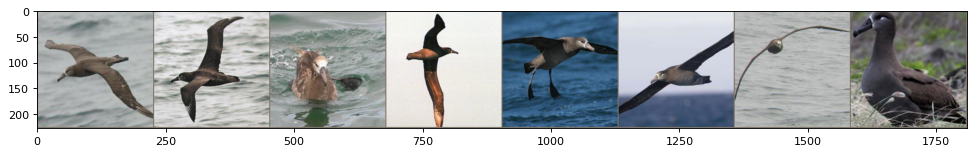

In [8]:
# CHECK CUSTOM DATALOADER
from matplotlib.pyplot import figure

def imshow_tensors(inp, title=None):
    """Imshow for Tensor."""
    figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, main_classes = next(iter(dataloaders_main['test']))

print(inputs.shape)
print(main_classes.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow_tensors(out, title = None)#title=[class_names[x] for x in main_classes])

# LOAD TRAINED SETEX MODEL

## MAIN MODEL

In [9]:
main_model = resnet50()
num_ftrs = main_model.fc.in_features
main_model.fc = nn.Linear(num_ftrs, 200)
if use_gpu:
    main_model = main_model.cuda()

checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/main_resnet50_best.pth')
main_model.load_state_dict(checkpoint['model'])
main_model.eval() # SET MAIN NETWORK TO EVAL MODE = FREEZE MAIN NETWORK

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# VALIDATE SAME TEST ACCURACY ON MAIN TASK
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def calc_main_accuracy(main_model, dataloader):
    main_model.eval()
    if use_gpu:
      main_model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = main_model.forward(Variable(inputs))[0]
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

top1, top5 = calc_main_accuracy(main_model, dataloaders_main['train'])
print('Train acc:', top1.avg, top5.avg)

top1, top5 = calc_main_accuracy(main_model, dataloaders_main['test'])
print('Test acc:', top1.avg, top5.avg)

Train acc: tensor(89.7064, device='cuda:0') tensor(95.5122, device='cuda:0')
Test acc: tensor(81.0321, device='cuda:0') tensor(95.3227, device='cuda:0')


## EXPLANATIONS MODEL

In [11]:
expl_model = Resnet_Expl()
if use_gpu:
    expl_model = expl_model.cuda()

checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/expl_resnet50_best.pth')
# checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/expl_ws_resnet50_best.pth')

expl_model.load_state_dict(checkpoint['model'])
expl_model.eval() # SET EXPL NETWORK TO EVAL MODE = FREEZE EXPL NETWORK

Resnet_Expl(
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [12]:
def calc_expl_accuracy(main_model, expl_model, dataloader):
    main_model.eval()
    expl_model.eval()
    if use_gpu:
      main_model.cuda()
      expl_model.cuda()
    
    top1 = AverageMeter()
    
    for idx, (inputs, attributes) in enumerate(dataloader):
        if use_gpu:
            inputs, attributes = inputs.cuda(), attributes.cuda()

        batch_size = inputs.size(0)
        denominator = torch.tensor(312*batch_size).float()

        # obtain the outputs from the model
        main_predictions, x0, x1, x2, x3, x4 = main_model(Variable(inputs))
        expl_predictions = expl_model(x0, x1, x2, x3, x4)
        preds = torch.sigmoid(expl_predictions).data > 0.5

        acc = torch.sum(preds == attributes.data)
        acc = acc.div(denominator)
        top1.update(acc, batch_size)
        # print(acc)
        
    return top1

acc = calc_expl_accuracy(main_model, expl_model, dataloaders_expl['train'])
print('Train acc:', acc.avg)

acc = calc_expl_accuracy(main_model, expl_model, dataloaders_expl['test'])
print('Test acc:', acc.avg)

Train acc: tensor(0.8539, device='cuda:0')
Test acc: tensor(0.8519, device='cuda:0')


# SETEX INFERENCE

In [13]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    return ax

def setex_predict(image_path, main_model, top_num=5, clean_explanations=True):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    

    # Main Probs
    main_predictions, x0, x1, x2, x3, x4 = main_model(Variable(model_input.cuda()))
    main_probs = torch.softmax(main_predictions, dim=1)
    # Top probs
    top_probs, top_labs = main_probs.topk(top_num)
    top_probs, top_labs = top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    top_birds = [class_names[lab] for lab in top_labs]


    # Expl Probs
    expl_preds = expl_model(x0, x1, x2, x3, x4).detach()
    nonsorted_expl_preds = torch.sigmoid(expl_preds).squeeze()
    expl_preds, expl_idxs = torch.sort(nonsorted_expl_preds, descending=True)
    # splitting = (expl_preds <= expl_threshold).nonzero()[0]
    pos_expl_preds, pos_expl_idxs = expl_preds, expl_idxs

    return top_probs, top_birds, pos_expl_preds.cpu().numpy(), pos_expl_idxs.cpu().numpy()

def clean_attributes(attributes):
    indexes_to_keep = []
    types_of_attributes_seen = []
    attributes_strings = attributes.index.values
    # print(attributes_strings)
    attributes_strings = list(map(lambda x: x.split(':')[0], attributes_strings))
    for idx, name in enumerate(attributes_strings):
        if name not in types_of_attributes_seen:
            indexes_to_keep.append(idx)
            types_of_attributes_seen.append(name)
    # print(len(indexes_to_keep))
    # print(types_of_attributes_seen)
    return attributes.iloc[indexes_to_keep]

def clean_full_attributes(attributes):
    indexes_to_keep = []
    indexes_to_not_keep = []
    types_of_attributes_seen = []
    attributes_strings = attributes.index.values
    # print(attributes_strings)
    attributes_strings = list(map(lambda x: x.split(':')[0], attributes_strings))
    for idx, name in enumerate(attributes_strings):
        if name not in types_of_attributes_seen:
            indexes_to_keep.append(idx)
            types_of_attributes_seen.append(name)
        else:
            indexes_to_not_keep.append(idx)
    # print(len(indexes_to_keep))
    # print(types_of_attributes_seen)
    return indexes_to_keep, indexes_to_not_keep

def inference_by_explanations(all_expl_probs, use_positive_weigths=True):
    product_class_probs = attributes_class_probs*all_expl_probs

    if use_positive_weigths:
        cum_probs = np.dot(product_class_probs, pos_weights_vector)
    else:
        cum_probs = product_class_probs.sum(axis=1)
    
    cum_probs = cum_probs / cum_probs.sum()
    sorted_cum_probs, idxs_cum_probs = np.sort(cum_probs)[::-1], np.argsort(cum_probs)[::-1]
    return sorted_cum_probs, idxs_cum_probs

def plot_main_prediction(image_path, main_model, expl_threshold=0.5, clean_explanations=True, clean_explanations_in_inference=True, apply_threshold_expl_inference=True, discretize_after_threshold=False, top_by_expl=5):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    title_ = image_path.split('/')[2]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, birds, sorted_expl_preds, sorted_expl_idxs = setex_predict(image_path, main_model, clean_explanations=clean_explanations)
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=birds, color=sns.color_palette()[0]);
    plt.show()

    pos_attributes = attributes.iloc[sorted_expl_idxs].copy()
    pos_attributes['score'] = sorted_expl_preds
    # pos_attributes = pos_attributes.drop('image_id', axis=1)
    pos_attributes = pos_attributes.set_index('attribute')
    attributes_no_threshold = pos_attributes.copy()
    pos_attributes = pos_attributes[pos_attributes['score'] > expl_threshold]
    # print(pos_attributes.head(30))
    # pos_attributes.plot.bar()

    # print(len(pos_attributes), 'positive attributes out of 312 before cleaning (ratio:',len(pos_attributes)/312,')')
    # print('Ratio:', len(pos_attributes)/312)
    if clean_explanations:
        # print('Cleaning repeated attributes...')
        pos_attributes = clean_attributes(pos_attributes)
        # print(len(pos_attributes), 'positive attributes out of 312 after cleaning (ratio:',len(pos_attributes)/312,')')

    ax = plt.figure(figsize=(5, int(len(pos_attributes)/2) ))
    sns.barplot(x=pos_attributes.score, y=pos_attributes.index, color=sns.color_palette()[0], orient='h')
    
    # MAKE INFERENCE BY EXPLANATIONS
    if clean_explanations_in_inference:
        indexes_to_keep, indexes_to_not_keep = clean_full_attributes(attributes_no_threshold)
        # print(attributes_no_threshold.score.values)
        attributes_no_threshold.score.iloc[indexes_to_not_keep] = 0
        # print(attributes_no_threshold.score.values)

    if apply_threshold_expl_inference:
        indexes_to_not_keep = attributes_no_threshold['score'] <= expl_threshold
        attributes_no_threshold.score[indexes_to_not_keep] = 0
        if discretize_after_threshold:
            attributes_no_threshold.score[~indexes_to_not_keep] = 1

    nonsorted_expl_preds = attributes_no_threshold.sort_values(by=['image_id'])['score'].values
    sorted_cum_probs, idxs_cum_probs = inference_by_explanations(nonsorted_expl_preds)
    classes_by_expl = classes.iloc[idxs_cum_probs].copy()
    classes_by_expl['score_by_explanations'] = sorted_cum_probs
    # classes_by_expl = classes_by_expl.drop('class', axis=1)
    classes_by_expl = classes_by_expl.set_index('class_name')
    classes_by_expl = classes_by_expl[:top_by_expl]
    # print(classes_by_expl)

    ax = plt.figure(figsize=(5, int(top_by_expl/2) ))
    sns.barplot(x=classes_by_expl.score_by_explanations, y=classes_by_expl.index, color=sns.color_palette()[0], orient='h')

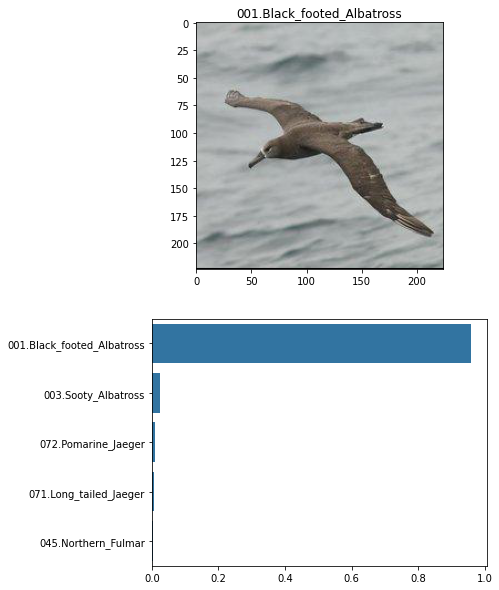

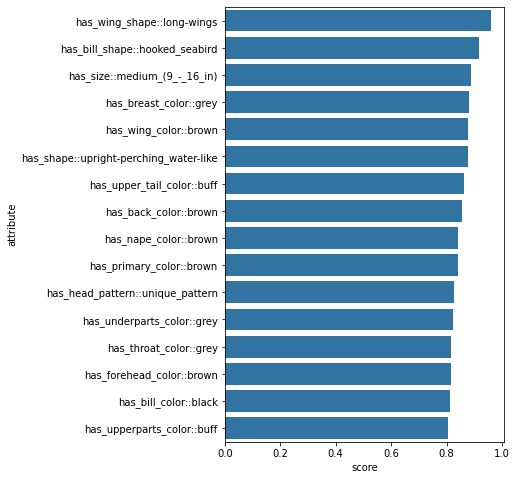

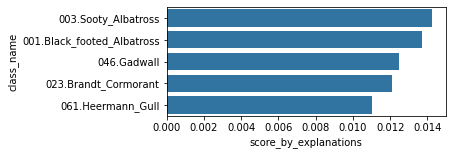

In [22]:
image_path = 'CUB_200_PyTorch/test/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
# image_path = 'CUB_200_PyTorch/test/015.Lazuli_Bunting/Lazuli_Bunting_0009_15163.jpg'
expl_threshold = 0.8
clean_explanations = True

# PARAMS FOR EXPLANATIONS INFERENCE
clean_explanations_in_inference = clean_explanations
apply_threshold_expl_inference = True
discretize_after_threshold = False
top_by_expl = 5

plot_main_prediction(image_path, main_model, expl_threshold=expl_threshold, clean_explanations=clean_explanations,
                     clean_explanations_in_inference=clean_explanations_in_inference, apply_threshold_expl_inference=apply_threshold_expl_inference,
                     discretize_after_threshold=discretize_after_threshold, top_by_expl=top_by_expl)

In [15]:
expl_threshold = 0.8
clean_explanations = True
# PARAMS FOR EXPLANATIONS INFERENCE
clean_explanations_in_inference = True
apply_threshold_expl_inference = True
discretize_after_threshold = False
top_by_expl = 10

test_dir = 'CUB_200_PyTorch/test/'
n = 50
for test_class in os.listdir(test_dir):
    test_path = test_dir + test_class
    for img_name in os.listdir(test_path):
        test_img_path = test_path + '/' + img_name
        plot_main_prediction(test_img_path, main_model, expl_threshold=expl_threshold, clean_explanations=clean_explanations,
                            clean_explanations_in_inference=clean_explanations_in_inference, apply_threshold_expl_inference=apply_threshold_expl_inference,
                            discretize_after_threshold=discretize_after_threshold, top_by_expl=top_by_expl)
        n -= 1
        if n==0: break
    if n==0: break

Output hidden; open in https://colab.research.google.com to view.

## OUT-OF-DISTRIBUTION

In [16]:
random_img = np.random.rand(256, 256, 3)

if not os.path.exists('CUB_200_PyTorch/test/Random_images/'):
    os.mkdir('CUB_200_PyTorch/test/Random_images/')
skimage.io.imsave('CUB_200_PyTorch/test/Random_images/random_1.jpg', random_img)

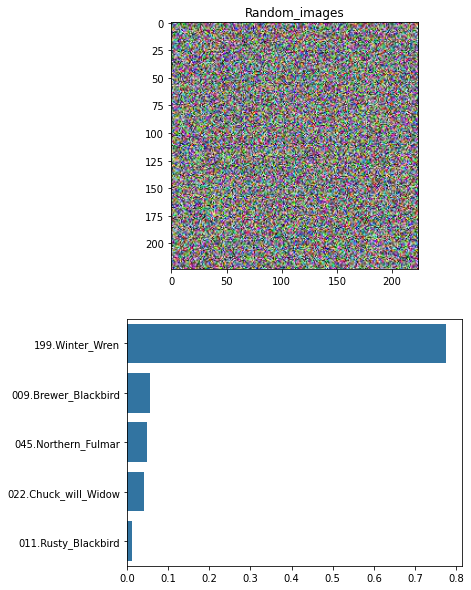

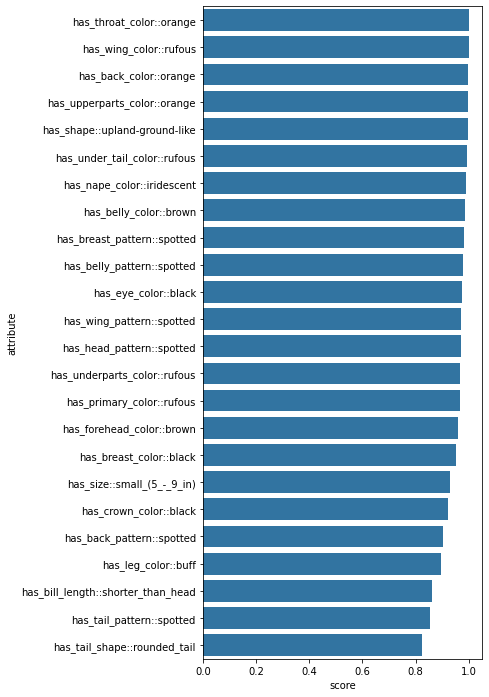

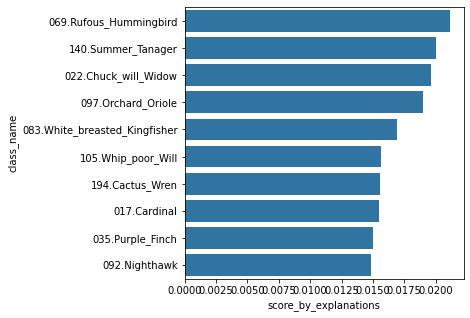

In [17]:
image_path = 'CUB_200_PyTorch/test/Random_images/random_1.jpg'
expl_threshold = 0.8
clean_explanations = True

# PARAMS FOR EXPLANATIONS INFERENCE
clean_explanations_in_inference = True
apply_threshold_expl_inference = True
discretize_after_threshold = False
top_by_expl = 10

plot_main_prediction(image_path, main_model, expl_threshold=expl_threshold, clean_explanations=clean_explanations,
                     clean_explanations_in_inference=clean_explanations_in_inference, apply_threshold_expl_inference=apply_threshold_expl_inference,
                     discretize_after_threshold=discretize_after_threshold, top_by_expl=top_by_expl)

In [46]:
def is_consistent_prediction(image_path, main_model, expl_threshold=0.5, clean_explanations=True, clean_explanations_in_inference=True, apply_threshold_expl_inference=True, discretize_after_threshold=False, top_by_expl=5):
    true_class = image_path.split('/')[2]
    
    # Make prediction
    probs, birds, sorted_expl_preds, sorted_expl_idxs = setex_predict(image_path, main_model, clean_explanations=clean_explanations)

    predicted_class = birds[0]

    pos_attributes = attributes.iloc[sorted_expl_idxs].copy()
    pos_attributes['score'] = sorted_expl_preds
    pos_attributes = pos_attributes.set_index('attribute')
    attributes_no_threshold = pos_attributes.copy()
    pos_attributes = pos_attributes[pos_attributes['score'] > expl_threshold]

    if clean_explanations:
        pos_attributes = clean_attributes(pos_attributes)
    
    # MAKE INFERENCE BY EXPLANATIONS
    if clean_explanations_in_inference:
        indexes_to_keep, indexes_to_not_keep = clean_full_attributes(attributes_no_threshold)
        attributes_no_threshold.score.iloc[indexes_to_not_keep] = 0

    if apply_threshold_expl_inference:
        indexes_to_not_keep = attributes_no_threshold['score'] <= expl_threshold
        attributes_no_threshold.score[indexes_to_not_keep] = 0
        if discretize_after_threshold:
            attributes_no_threshold.score[~indexes_to_not_keep] = 1

    nonsorted_expl_preds = attributes_no_threshold.sort_values(by=['image_id'])['score'].values
    sorted_cum_probs, idxs_cum_probs = inference_by_explanations(nonsorted_expl_preds)
    classes_by_expl = classes.iloc[idxs_cum_probs].copy()
    classes_by_expl['score_by_explanations'] = sorted_cum_probs
    classes_by_expl = classes_by_expl.set_index('class_name')
    classes_by_expl = classes_by_expl[:top_by_expl]

    # print(true_class, predicted_class, classes_by_expl.index)
    return predicted_class in classes_by_expl.index, true_class == predicted_class

In [ ]:
expl_threshold = 0.8
clean_explanations = True
clean_explanations_in_inference = clean_explanations
apply_threshold_expl_inference = True
discretize_after_threshold = False
top_by_expl = 10

correctly_classified = 0
correctly_classified_and_consistent = 0
not_correctly_classified = 0
not_correctly_classified_and_not_consistent = 0


test_dir = 'CUB_200_PyTorch/test/'
n = 99999999
for test_class in tqdm(os.listdir(test_dir)):
    test_path = test_dir + test_class
    for img_name in os.listdir(test_path):
        test_img_path = test_path + '/' + img_name

        if len( skimage.io.imread(test_img_path).shape ) != 3: continue

        is_consistent, is_correctly_classified = is_consistent_prediction(test_img_path, main_model, expl_threshold=expl_threshold, clean_explanations=clean_explanations,
                            clean_explanations_in_inference=clean_explanations_in_inference, apply_threshold_expl_inference=apply_threshold_expl_inference,
                            discretize_after_threshold=discretize_after_threshold, top_by_expl=top_by_expl)
        
        # print(is_consistent, is_correctly_classified)

        if is_correctly_classified:
            correctly_classified += 1
            if is_consistent:
                correctly_classified_and_consistent += 1
        else:
            not_correctly_classified += 1
            if not is_consistent:
                not_correctly_classified_and_not_consistent += 1

        n -= 1
        if n==0: break
    if n==0: break

print(correctly_classified)
print(correctly_classified_and_consistent)

print(not_correctly_classified)
print(not_correctly_classified_and_not_consistent)

In [50]:
print(correctly_classified)
print(correctly_classified_and_consistent)

print(not_correctly_classified)
print(not_correctly_classified_and_not_consistent)

4623
3927
1171
415


In [52]:
def random_process_image():
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    img = np.random.rand(256, 256, 3)
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

def random_setex_predict(main_model, top_num=5, clean_explanations=True):
    # Process image
    img = random_process_image()
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    

    # Main Probs
    main_predictions, x0, x1, x2, x3, x4 = main_model(Variable(model_input.cuda()))
    main_probs = torch.softmax(main_predictions, dim=1)
    # Top probs
    top_probs, top_labs = main_probs.topk(top_num)
    top_probs, top_labs = top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    top_birds = [class_names[lab] for lab in top_labs]


    # Expl Probs
    expl_preds = expl_model(x0, x1, x2, x3, x4).detach()
    nonsorted_expl_preds = torch.sigmoid(expl_preds).squeeze()
    expl_preds, expl_idxs = torch.sort(nonsorted_expl_preds, descending=True)
    # splitting = (expl_preds <= expl_threshold).nonzero()[0]
    pos_expl_preds, pos_expl_idxs = expl_preds, expl_idxs

    return top_probs, top_birds, pos_expl_preds.cpu().numpy(), pos_expl_idxs.cpu().numpy()

def is_random_consistent_prediction(main_model, expl_threshold=0.5, clean_explanations=True, clean_explanations_in_inference=True, apply_threshold_expl_inference=True, discretize_after_threshold=False, top_by_expl=5):
    true_class = 'Random_image'
    
    # Make prediction
    probs, birds, sorted_expl_preds, sorted_expl_idxs = random_setex_predict(main_model, clean_explanations=clean_explanations)

    predicted_class = birds[0]

    pos_attributes = attributes.iloc[sorted_expl_idxs].copy()
    pos_attributes['score'] = sorted_expl_preds
    pos_attributes = pos_attributes.set_index('attribute')
    attributes_no_threshold = pos_attributes.copy()
    pos_attributes = pos_attributes[pos_attributes['score'] > expl_threshold]

    if clean_explanations:
        pos_attributes = clean_attributes(pos_attributes)
    
    # MAKE INFERENCE BY EXPLANATIONS
    if clean_explanations_in_inference:
        indexes_to_keep, indexes_to_not_keep = clean_full_attributes(attributes_no_threshold)
        attributes_no_threshold.score.iloc[indexes_to_not_keep] = 0

    if apply_threshold_expl_inference:
        indexes_to_not_keep = attributes_no_threshold['score'] <= expl_threshold
        attributes_no_threshold.score[indexes_to_not_keep] = 0
        if discretize_after_threshold:
            attributes_no_threshold.score[~indexes_to_not_keep] = 1

    nonsorted_expl_preds = attributes_no_threshold.sort_values(by=['image_id'])['score'].values
    sorted_cum_probs, idxs_cum_probs = inference_by_explanations(nonsorted_expl_preds)
    classes_by_expl = classes.iloc[idxs_cum_probs].copy()
    classes_by_expl['score_by_explanations'] = sorted_cum_probs
    classes_by_expl = classes_by_expl.set_index('class_name')
    classes_by_expl = classes_by_expl[:top_by_expl]

    # print(true_class, predicted_class, classes_by_expl.index)
    return predicted_class in classes_by_expl.index, true_class == predicted_class

In [53]:
expl_threshold = 0.8
clean_explanations = True
clean_explanations_in_inference = clean_explanations
apply_threshold_expl_inference = True
discretize_after_threshold = False
top_by_expl = 10

correctly_classified = 0
correctly_classified_and_consistent = 0
not_correctly_classified = 0
not_correctly_classified_and_not_consistent = 0

n = 1000
for test_class in tqdm(range(n)):

    is_consistent, is_correctly_classified = is_random_consistent_prediction(main_model, expl_threshold=expl_threshold, clean_explanations=clean_explanations,
                        clean_explanations_in_inference=clean_explanations_in_inference, apply_threshold_expl_inference=apply_threshold_expl_inference,
                        discretize_after_threshold=discretize_after_threshold, top_by_expl=top_by_expl)
    
    # print(is_consistent, is_correctly_classified)

    if is_correctly_classified:
        correctly_classified += 1
        if is_consistent:
            correctly_classified_and_consistent += 1
    else:
        not_correctly_classified += 1
        if not is_consistent:
            not_correctly_classified_and_not_consistent += 1

print(correctly_classified)
print(correctly_classified_and_consistent)

print(not_correctly_classified)
print(not_correctly_classified_and_not_consistent)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<02:11,  7.62it/s]

  0%|          | 2/1000 [00:00<02:19,  7.14it/s]

  0%|          | 3/1000 [00:00<02:24,  6.89it/s]

  0%|          | 4/1000 [00:00<02:27,  6.74it/s]

  0%|          | 5/1000 [00:00<02:29,  6.65it/s]

  1%|          | 6/1000 [00:00<02:31,  6.56it/s]

  1%|          | 7/1000 [00:01<02:32,  6.53it/s]

  1%|          | 8/1000 [00:01<02:31,  6.53it/s]

  1%|          | 9/1000 [00:01<02:33,  6.45it/s]

  1%|          | 10/1000 [00:01<02:34,  6.42it/s]

  1%|          | 11/1000 [00:01<02:33,  6.44it/s]

  1%|          | 12/1000 [00:01<02:35,  6.35it/s]

  1%|▏         | 13/1000 [00:02<02:34,  6.39it/s]

  1%|▏         | 14/1000 [00:02<02:33,  6.42it/s]

  2%|▏         | 15/1000 [00:02<02:35,  6.35it/s]

  2%|▏         | 16/1000 [00:02<02:33,  6.39it/s]

  2%|▏         | 17/1000 [00:02<02:32,  6.43it/s]

  2%|▏         | 18/1000 [00:02<02:32,  6.46it/s]

  2%|▏         | 19/1000 [00:02<02:35,  6.31it/

False
0
1000
1000


In [56]:
print(correctly_classified)
print(correctly_classified_and_consistent)

print(not_correctly_classified)
print(not_correctly_classified_and_not_consistent)

0
0
1000
1000
